# Installs

In [2]:
import torch;
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.1+cpu
None
False


In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [4]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import qutip
from qutip import Bloch
import matplotlib
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
from pytorch_lightning.callbacks import Callback

from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

import numpy as np
import pandas as pd
import kmapper as km
import networkx as nx
from copy import copy

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
optax not installed, `optimizer` from jax backend cannot work


0.12.0


In [5]:
jax.devices()

[CpuDevice(id=0)]

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


# QUANTUM MODEL


In [8]:
def get_circ(nqubits, nlayers, x, weights):

    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)
        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
    return c

# test = None;

def circuit_wrapper(nqubits, nlayers):
    # global test
    # We define the quantum function,
    # note how this function is running on jax
    def qpred(x, weights):
        # global test
        # print(x.shape, "In wrapper", x)
        circuit = get_circ(nqubits, nlayers, x, weights)
        # print(circuit)
        # test = circuit
        # print(K.real(jnp.array(circuit.expectation_ps(z=[1]))))
        return K.real(jnp.array([circuit.expectation_ps(z=[i]) for i in range(nqubits)]))

    # `qpred_vmap` is a jax function with vectorization capacity
    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)

    # Wrap the function into pytorch form but with jax speed!
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)

    return qpred_batch

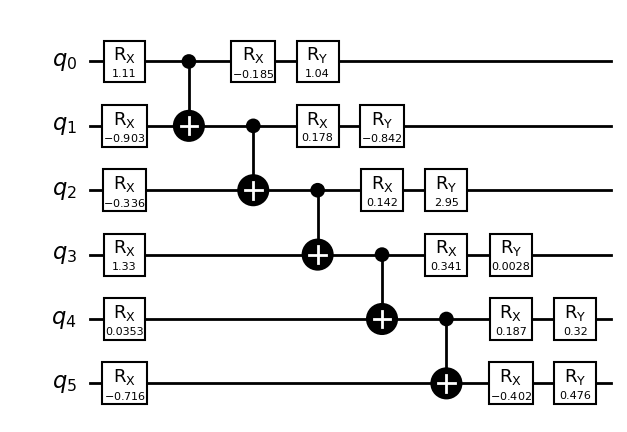

In [9]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 1
w = torch.randn([2 * nlayers, nqubits])
dummy_x = torch.randn([3, nqubits])

fig = get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)
fig

In [10]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [11]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    print(dummy_x.shape, dummy_x)
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad, yps)

torch.Size([3, 6]) tensor([[ 1.1115, -0.9030, -0.3355,  1.3254,  0.0353, -0.7164],
        [ 1.0965, -0.0929,  0.2436,  0.3755,  0.3145,  2.0272],
        [ 0.2104, -0.1961,  0.0420, -0.0288,  0.6048,  0.3161]])
tensor([[ 0.1749, -0.1987,  0.2304, -0.4790, -0.2189, -0.2359],
        [-1.5908,  1.2401, -0.3068, -0.0038, -0.3833, -0.3627]]) tensor([[ 0.2211,  0.1799, -0.2521,  0.0593,  0.0587,  0.0244],
        [ 0.2278,  0.2980, -0.4292,  0.3869,  0.3642, -0.0188],
        [ 0.4878,  0.6285, -0.9320,  0.9027,  0.7351,  0.6978]],
       grad_fn=<FunBackward>)


In [12]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)

        self.nqubits = nqubits
        self.nlayers = nlayers

    def forward(self, inputs):
#         print("Inside quantum net", inputs.shape)
        ypred = self.qpred_batch(inputs, self.q_weights)
#         print("output of qpred", ypred.shape)
        return ypred

In [13]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

tensor([[ 0.5121,  0.3018,  0.2181,  0.0129, -0.0457, -0.0593],
        [ 0.5753,  0.2271,  0.0390,  0.0104, -0.0450,  0.2583],
        [ 0.7400,  0.2342,  0.2216,  0.0058, -0.0327, -0.1068]],
       grad_fn=<FunBackward>)
torch.Size([3, 6])


In [14]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers = 2,
        **kwargs,
    ):
        super().__init__(in_channels,
                        out_channels,
                        improved,
                        cached,
                        add_self_loops,
                        normalize,
                        bias,
                        **kwargs)
        self.lin = QuantumNet(in_channels, nlayers)

#### This part is testing the QGCNonv model

In [16]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import pytorch_lightning as pl
from torch_geometric.nn import global_mean_pool
from torchmetrics.classification import Accuracy


In [17]:
from torchmetrics.classification import Accuracy

class GraphModel(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, out_channels, nlayers=1):
        super().__init__()
        self.conv1 = QGCNConv(in_channels, hidden_channels, nlayers)
        self.conv2 = QGCNConv(hidden_channels, out_channels, nlayers)
        self.lin = torch.nn.Linear(out_channels, 2)  # For binary classification
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

    def training_step(self, batch, batch_idx):
        out = self(batch)
        loss = F.cross_entropy(out, batch.y)
        preds = torch.argmax(out, dim=1)
        acc = self.train_accuracy(preds, batch.y)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        out = self(batch)
        loss = F.cross_entropy(out, batch.y)
        preds = torch.argmax(out, dim=1)
        acc = self.val_accuracy(preds, batch.y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)

    def on_validation_epoch_end(self):
        # Called at the end of each validation epoch
        avg_val_acc = self.val_accuracy.compute()
        self.log("epoch_val_acc", avg_val_acc, prog_bar=True)
        self.val_accuracy.reset()  # Reset for the next epoch

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [18]:
# Create a simple synthetic graph dataset
def create_synthetic_data():
    edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)  # Simple graph edges
    x = torch.rand((3, 8), dtype=torch.float)  # Node features (3 nodes, 5 features per node)
    y = torch.tensor([0], dtype=torch.long)    # Graph label (binary classification)
    data = Data(x=x, edge_index=edge_index, y=y)
    return [data] * 10  # Return a list of the same graph data to form a small dataset

In [19]:
# Create data loaders
train_dataset = create_synthetic_data()
train_loader = DataLoader(train_dataset, batch_size=2)

# Initialize model, trainer, and start training
model = GraphModel(in_channels=8, hidden_channels=8, out_channels=8, nlayers=1)
trainer = pl.Trainer(max_epochs=5, accelerator="cpu", enable_progress_bar=True)
trainer.fit(model, train_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | conv1          | QGCNConv       | 40     | train
1 | conv2          | QGCNConv       | 40     | train
2 | lin            | Linear         | 18     | train
3 | train_accuracy | BinaryAccuracy | 0      | train
4 | val_accuracy   | BinaryAccuracy | 0      | train
----------------------------------------------------------
98        Trainable params
0         Non-trainable params
98        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|█| 5/5 [00:00<00:00, 132.97it/s, v_num=4, train_loss_step=0.457, train_acc_step=1.000, train_loss_epoch=0

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 5/5 [00:00<00:00, 117.36it/s, v_num=4, train_loss_step=0.457, train_acc_step=1.000, train_loss_epoch=0


# Finance Dataset

### Functions

In [22]:
def count_fraud_percentage(df, fraud_col='isFraud'):
    """
    Calculate the count and percentage of fraud cases in a DataFrame.

    """

    fraud_count = df[fraud_col].sum()

    total_count = len(df)
    fraud_percentage = (fraud_count / total_count) * 100

    return fraud_count, fraud_percentage

In [24]:
from imblearn.over_sampling import SMOTE
import pandas as pd

from imblearn.over_sampling import SMOTE
import pandas as pd

def balance_with_smote(df, target_col='isFraud', smote_ratio=0.2, random_state=42):
    """Apply SMOTE to increase the minority class size by a specified ratio."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Apply SMOTE with a limited ratio
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[target_col] = y_resampled
    return balanced_df

### Loading

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv("../../Datasets/PS_20174392719_1491204439457_log.csv",delimiter=',')

In [29]:
# Sort by 'step' to ensure time ordering
finance_df_sorted = df.sort_values(by='step')

# Calculate the interval for sampling evenly across time
interval = len(finance_df_sorted) // 10000

# Sample the dataset
sampled_df = finance_df_sorted.iloc[::interval][:10000]

# Display or save the sampled dataset
sampled_df.reset_index(drop=True, inplace=True)
print(sampled_df)


      step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0        1   PAYMENT    9839.64  C1231006815       170136.0       160296.36   
1        1   PAYMENT    9614.73  C1789282489       275664.0       266049.27   
2        1   PAYMENT    4280.41   C589016913       253537.0       249256.59   
3        1   PAYMENT    4802.31   C424786033            0.0            0.00   
4        1   PAYMENT    8348.75   C858423246            0.0            0.00   
...    ...       ...        ...          ...            ...             ...   
9995   710   CASH_IN  323073.91  C1912580262        20364.0       343437.91   
9996   710     DEBIT    9774.24   C169337305        20759.0        10984.76   
9997   714   PAYMENT    6478.07  C1896033561       263446.0       256967.93   
9998   714  CASH_OUT   31106.04  C1442274936        47295.0        16188.96   
9999   715   CASH_IN  100878.16   C698031251          845.0       101723.16   

         nameDest  oldbalanceDest  newbalanceDest  

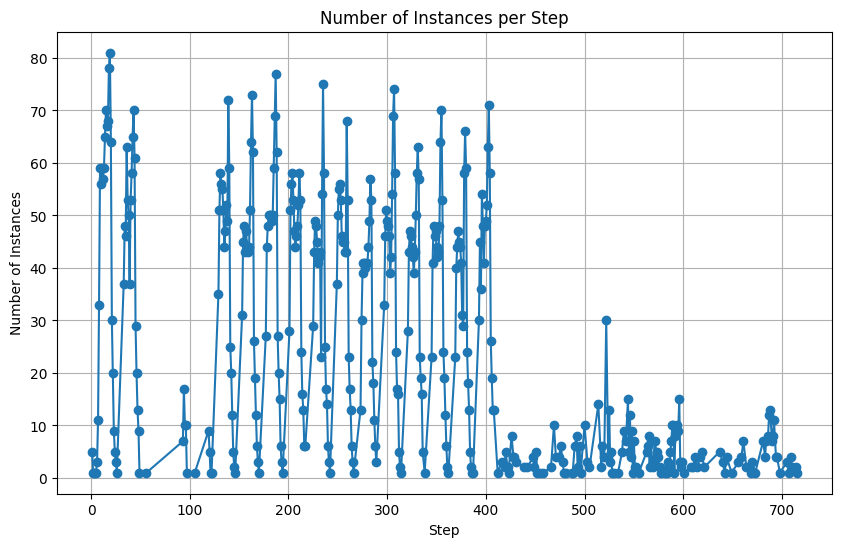

In [30]:
import matplotlib.pyplot as plt

# Count instances for each step
step_counts = sampled_df['step'].value_counts().sort_index()

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(step_counts.index, step_counts.values, marker='o')
plt.title("Number of Instances per Step")
plt.xlabel("Step")
plt.ylabel("Number of Instances")
plt.grid()
plt.show()

In [31]:
finance_df=sampled_df

In [32]:
finance_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.00000,10000.0000
mean,243.164400,1.731438e+05,8.295211e+05,8.513496e+05,1.103150e+06,1.220167e+06,0.00110,0.0001
std,142.012192,4.686762e+05,2.907622e+06,2.943767e+06,3.465637e+06,3.761877e+06,0.03315,0.0100
min,1.000000,7.330000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.0000
25%,155.000000,1.331523e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.0000
50%,239.000000,7.669155e+04,1.241626e+04,0.000000e+00,1.423281e+05,2.228901e+05,0.00000,0.0000
75%,334.000000,2.084735e+05,1.063798e+05,1.480112e+05,9.811898e+05,1.155956e+06,0.00000,0.0000
max,715.000000,1.975998e+07,3.383136e+07,3.413713e+07,1.542198e+08,1.544375e+08,1.00000,1.0000


In [33]:
finance_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,9614.73,C1789282489,275664.0,266049.27,M600199331,0.00,0.00,0,0
2,1,PAYMENT,4280.41,C589016913,253537.0,249256.59,M293870357,0.00,0.00,0,0
3,1,PAYMENT,4802.31,C424786033,0.0,0.00,M1545077099,0.00,0.00,0,0
4,1,PAYMENT,8348.75,C858423246,0.0,0.00,M1419125235,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,710,CASH_IN,323073.91,C1912580262,20364.0,343437.91,C1551617588,0.00,0.00,0,0
9996,710,DEBIT,9774.24,C169337305,20759.0,10984.76,C1749982430,84043.32,93817.57,0,0
9997,714,PAYMENT,6478.07,C1896033561,263446.0,256967.93,M1533299419,0.00,0.00,0,0
9998,714,CASH_OUT,31106.04,C1442274936,47295.0,16188.96,C752464439,1580534.19,1611640.23,0,0


### Cleaning

In [35]:
df_cleaned = finance_df.loc[(finance_df['type'].isin(['CASH_OUT', 'TRANSFER'])),:]

In [36]:

df_cleaned

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
9,6,CASH_OUT,7106.23,C1718103695,0.00,0.00,C1445567246,30691.00,37797.23,0,0
11,6,TRANSFER,820399.29,C1775601457,0.00,0.00,C1255024717,7829762.55,10833791.00,0,0
12,7,CASH_OUT,10118.23,C2057029313,0.00,0.00,C33837320,29207.00,0.00,0,0
15,7,TRANSFER,437410.02,C1478168970,100589.00,0.00,C1456465598,17384.73,87715.94,0,0
19,7,TRANSFER,77606.35,C2021891118,674.00,0.00,C2059996587,94379.74,322941.28,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9989,705,CASH_OUT,211885.07,C434222788,261.00,0.00,C330133641,1095404.98,1307290.05,0,0
9990,707,CASH_OUT,14766.41,C2011190630,0.00,0.00,C838067560,4227848.55,4242614.96,0,0
9991,709,CASH_OUT,20017.53,C1185617573,216874.98,196857.46,C1231270151,439584.98,459602.51,0,0
9992,709,TRANSFER,222499.53,C1745199651,20372.00,0.00,C741632771,481863.39,704362.92,0,0


In [37]:
df_cleaned = finance_df.loc[(finance_df['type'].isin(['CASH_OUT', 'TRANSFER'])),:]
df_cleaned.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)
df_cleaned['type'] = finance_df['type'].map({'CASH_OUT': 0, 'TRANSFER': 1})
df_cleaned

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
9,6,0.0,7106.23,0.00,0.00,30691.00,37797.23,0
11,6,1.0,820399.29,0.00,0.00,7829762.55,10833791.00,0
12,7,0.0,10118.23,0.00,0.00,29207.00,0.00,0
15,7,1.0,437410.02,100589.00,0.00,17384.73,87715.94,0
19,7,1.0,77606.35,674.00,0.00,94379.74,322941.28,0
...,...,...,...,...,...,...,...,...
9989,705,0.0,211885.07,261.00,0.00,1095404.98,1307290.05,0
9990,707,0.0,14766.41,0.00,0.00,4227848.55,4242614.96,0
9991,709,0.0,20017.53,216874.98,196857.46,439584.98,459602.51,0
9992,709,1.0,222499.53,20372.00,0.00,481863.39,704362.92,0


In [38]:
df_smote_balanced = balance_with_smote(df_cleaned, target_col='isFraud', smote_ratio=0.2, random_state=42)
fraud_count_smote, fraud_percentage_smote = count_fraud_percentage(df_smote_balanced)
print(f"After SMOTE - Fraudulent: {fraud_count_smote}, Fraud Percentage: {fraud_percentage_smote:.2f}%")

After SMOTE - Fraudulent: 867, Fraud Percentage: 16.66%


In [39]:
final_df=df_smote_balanced

In [40]:
final_df = final_df.sort_values(by='step').astype(float)

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_df[final_df.columns] = scaler.fit_transform(final_df[final_df.columns])
final_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.000000,0.0,0.000357,0.000000,0.000000,0.000199,0.000245,0.0
1,0.000000,1.0,0.041516,0.000000,0.000000,0.050770,0.070150,0.0
2,0.001412,0.0,0.000509,0.000000,0.000000,0.000189,0.000000,0.0
3,0.001412,1.0,0.022134,0.018753,0.000000,0.000113,0.000568,0.0
4,0.001412,1.0,0.003925,0.000126,0.000000,0.000612,0.002091,0.0
...,...,...,...,...,...,...,...,...
4342,0.987288,0.0,0.008135,0.002714,0.000000,0.021083,0.022094,0.0
4344,0.990113,0.0,0.000745,0.000000,0.000000,0.027414,0.027471,0.0
4346,0.992938,1.0,0.011257,0.003798,0.000000,0.003125,0.004561,0.0
4345,0.992938,0.0,0.001010,0.040433,0.040239,0.002850,0.002976,0.0


In [42]:
print(type(final_df))

<class 'pandas.core.frame.DataFrame'>


### Processing

In [44]:
def get_graph(nx_graph, data, row):
  nodes = list(nx_graph.nodes());
  edges = list(nx_graph.edges());
  feature = [];
  for n in nodes:
    mem = np.array(nx_graph._node[n]['membership']);
    id = np.zeros(5, dtype = int);
    id[mem] = 1;
    ft = data * id;
    feature.append(ft)
  edges = np.array(list(map(lambda x: (nodes.index(x[0]), nodes.index(x[1])),edges)))
  nodes = np.array(list(map(lambda x: nodes.index(x),nodes)))
  return nodes, edges.transpose(), np.array(feature);

In [45]:
fraud_id = final_df.isFraud[final_df.isFraud.eq(1)].index
nofraud_id = final_df.isFraud[final_df.isFraud.eq(0)].sample(len(fraud_id)*3).index

df_reduced = final_df.loc[fraud_id.union(nofraud_id)].sample(frac = 1).reset_index( drop = True);

In [46]:
print(fraud_id.shape, nofraud_id.shape)

(867,) (2601,)


In [47]:
df_reduced.shape

(3468, 8)

In [48]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [49]:
import sklearn

In [50]:
mp = km.KeplerMapper()
# Initializes KeplerMapper to create topological data visualizations.

transform = T.Compose([T.Pad(max_num_nodes=16, max_num_edges=5, mask_pad_value=True)])
# Defines a transformation pipeline to pad node and edge counts to fixed sizes.

def get_data(df):
    data_list = []
    # List to store processed graph data objects.

    nodes_dist, edges_dist = [], []
    # Lists to track node and edge distributions for each graph.

    graphs = []
    # List to store graph structures for further use.

    for i in range(df.shape[0]):
        data_row = df.loc[i, df.columns[1:6]].to_numpy()
        # Extracts specific columns as features for each row.

        data = data_row.transpose()
        # print(data)
        # Transposes features to match the input shape for KeplerMapper.

        Y = df.iloc[i, 7]
        # print(Y)
        # Extracts target label for the row.

        amt = df.iloc[i, 2]
        # print(amt)
        # Extracts the 'amount' feature for each row.

        time = df.iloc[i, 0]
        # print(time)
        # Extracts the 'time' feature for each row.

        amt = np.repeat(amt, data.shape[0])
        # print(amt)
        # Repeats the amount value for all data points in the row.

        time = np.repeat(time, data.shape[0])
        # print(time)
        # Repeats the time value for all data points in the row.

        data = np.stack((data, amt, time), axis=1)
        # print("Data here: ",data)
        # Stacks the features, amount, and time into a single array.

        lens = mp.project(data)
        # print(lens)
        # Projects data into a lower-dimensional lens for mapping.
        # Create the graph
        graph = mp.map(
            X=data,
            lens=lens,
            clusterer=sklearn.cluster.DBSCAN(eps=0.5, min_samples=1),
            cover=km.Cover(n_cubes=10, perc_overlap=0.2)
        )
        # print(f"Graph nodes: {len(graph['nodes'])}")
        # print(f"Graph links: {len(graph['links'])}")

        nx_graph = km.adapter.to_nx(graph)

        nx_graph = km.adapter.to_nx(graph)
        # print(nx_graph)
        # Converts the mapper's graph structure into a NetworkX graph.

        nodes, edges, features = get_graph(nx_graph, data_row, i)
        # Extracts nodes, edges, and features from the graph.

        nodes_dist.append(len(nodes))
        # Appends the number of nodes in the graph.

        edges_dist.append(0 if len(edges) == 0 else edges.shape[1])
        # Appends the number of edges (or zero if no edges exist).

        data_list.append(
            geom_data.Data(
                x=torch.tensor(features, dtype=torch.float),
                # Stores node features as a PyTorch tensor.
                edge_index=torch.tensor(edges, dtype=torch.int64),
                # Stores edge indices as a PyTorch tensor.
                y=torch.tensor(Y)
            )
        )

        graphs.append((nx_graph, nodes, edges, features))

        # break

    return data_list, graphs

In [51]:
data_list, graphs = get_data(df_reduced)

In [52]:
batch_s = 64;
split = int(len(data_list) * 0.75);
graph_train_loader = geom_data.DataLoader(data_list[:split], batch_size=batch_s,shuffle=True)
graph_val_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)
graph_test_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)

In [53]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y)
print("Batch indices:", batch.batch)
print("Batch ptr:", batch.ptr)

Batch: DataBatch(x=[203, 5], edge_index=[2, 20], y=[64], batch=[203], ptr=[65])
Labels: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)
Batch indices: tensor([ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10,
        11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 15,
        16, 16, 16, 17, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 22, 23,
        23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 36,
        36, 36, 36, 37, 37, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41,
        41, 42, 42, 42, 42,

#Models

In [55]:
class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="QGCN", dp_rate=0.1, dp_rate_linear=0.5, version=0, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate applied throughout the network
            dp_rate_linear - Dropout rate before the final linear layer
            version - Determines the model type: 0 (pure quantum), 1 (pure classical), 2 (hybrid)
            kwargs - Additional arguments for the graph layers (e.g. number of heads for GAT)
        """
        super().__init__()
        # Embedding layer
        self.embed = nn.Linear(c_in, c_hidden)
        self.dropout_embed = nn.Dropout(dp_rate)

        # Define layers based on the version
        self.qgnn_layer = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        in_channels = c_hidden

        for _ in range(num_layers - 1):
            if version == 0:  # Pure Quantum
                layer = QGCNConv(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
            elif version == 1:  # Pure Classical
                layer = geom_nn.GCNConv(in_channels=in_channels, out_channels=c_hidden, **kwargs)
            elif version == 2:  # Hybrid
                if _ % 2 == 0:  # Alternate between quantum and classical
                    layer = QGCNConv(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
                else:
                    layer = geom_nn.GCNConv(in_channels=in_channels, out_channels=c_hidden, **kwargs)
            else:
                raise ValueError("Invalid version. Choose 0 (pure quantum), 1 (pure classical), or 2 (hybrid).")

            self.qgnn_layer.append(layer)
            self.dropouts.append(nn.Dropout(dp_rate))
            in_channels = c_hidden

        # Add final layer
        if version == 0:  # Pure Quantum
            layer = QGCNConv(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
        elif version == 1:  # Pure Classical
            layer = geom_nn.GCNConv(in_channels=in_channels, out_channels=c_hidden, **kwargs)
        elif version == 2:  # Hybrid
            layer = QGCNConv(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
        self.qgnn_layer.append(layer)
        self.dropouts.append(nn.Dropout(dp_rate))

        # Final prediction head
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph
                         (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        # Embedding step
        x = self.embed(x)
        x = self.dropout_embed(x)

        # QGNN processing
        for qgnn_layer, dropout in zip(self.qgnn_layer, self.dropouts):
            if isinstance(qgnn_layer, geom_nn.MessagePassing):
                x = qgnn_layer(x, edge_index)
            else:
                x = qgnn_layer(x)
            x = dropout(x)

        # Graph-level pooling
        x = geom_nn.global_mean_pool(x, batch_idx)

        # Final prediction
        x = self.head(x)

        return x


In [56]:
def get_prob(probs):
  ex = probs.exp();
  return ex / ex.sum();

class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.model = GraphGNNModel(**model_kwargs).to(device);
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()
        self.one_cycle_max_lr = 1e-1
        self.one_cycle_total_steps = 100
        self.test_prob = [];
        self.test_actual = [];

    def forward(self, tdata, mode="train"):
        data = tdata

        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float() # Positive means fraud
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]

        # print("After model", x, preds)

        target = data.y.cpu().numpy();
        predicton = preds.cpu().numpy();

        cm = confusion_matrix(target,predicton);
        ac = accuracy_score(target,predicton);
        ps = precision_score(target,predicton);
        rs = recall_score(target,predicton);
        fs = f1_score(target,predicton);

        # print("Values", cm)
        if mode == "test":
          return loss, acc, cm, ac, ps, rs, fs, target, get_prob(x).cpu().numpy();
        else :
          return loss, acc, cm, ac, ps, rs, fs;

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.001)
        return optimizer
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=self.one_cycle_max_lr, total_steps=self.one_cycle_total_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="train")
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        # print(loss)
        # print("Training called for: ", batch_idx);
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="val")
        self.log('val_acc', acc, prog_bar=True, batch_size=batch_s)
        self.log('val_loss', loss, prog_bar=True, batch_size=batch_s)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs, y, x  = self.forward(batch, mode="test")
        self.log('test_acc', acc, on_step=False, on_epoch=True, batch_size=batch_s)
        # self.log('test_cm', cm.tolist(), on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ac', ac, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ps', ps, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_rs', rs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_fs', fs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.test_prob.extend(x.tolist());
        self.test_actual.extend(y.tolist());

# Trainer

In [58]:
from time import time

CHECKPOINT_PATH = "/content/checkpoints"

class MetricTracker(Callback):

  def __init__(self):
    self.collection = []

  def on_train_epoch_end(self, trainer, module):
    metric = trainer.logged_metrics.copy();
    self.collection.append(metric)
    # print("train trainer end", trainer.logged_metrics)

def disp_loss(trainer):
  # print(trainer.callbacks[2].collection)

  train_loss = list(map(lambda x: x['train_loss'].item(),
                        trainer.callbacks[2].collection));
  val_loss = list(map(lambda x: x['val_loss'].item(),
                        trainer.callbacks[2].collection));

  # print(range(len(train_loss)), train_loss)
  fig = plt.figure();
  plt.plot(range(len(train_loss)), train_loss, color = 'b', label = 'Training Loss');
  plt.plot(range(len(val_loss)),val_loss, color = 'r', label = 'Validation Loss');

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  # Adding legend, which helps us recognize the curve according to it's color
  plt.legend()
  plt.show();
  fig.savefig('Quantum_Loss.pdf', format='pdf', dpi=300, bbox_inches='tight');


In [59]:
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, ModelSummary, LearningRateMonitor
from time import time

In [60]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["XLA_PTX_ASM_COMPILATION"] = "0"

!rm -rf /tmp/*


def train_graph_classifier(model_name, num_epochs=10, **model_kwargs):
    pl.seed_everything(42)

    # Setup callbacks without specifying a root directory for checkpointing
    callbacks = [
        ModelSummary(max_depth=4),
        LearningRateMonitor(logging_interval='epoch'),
        ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min"),  # Save best model by validation loss
        MetricTracker()  # Assumes MetricTracker is defined elsewhere
    ]

    # Initialize the trainer
    trainer = pl.Trainer(
        callbacks=callbacks,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        log_every_n_steps=2,
        max_epochs=num_epochs,
        enable_progress_bar=True
    )

    #########################    MODEL   #############################
    model = GraphLevelGNN(c_in=5, c_out=1, **model_kwargs).to(device)
    ##################################################################


    s = time()
    trainer.fit(model, graph_train_loader, graph_val_loader)
    e = time()

    # Display loss progression
    disp_loss(trainer)

    # Test best model on validation and test sets
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    test_y, test_prob = model.test_actual, model.test_prob
    train_result = trainer.test(model, graph_train_loader, verbose=False)

    # Collect test and train results for specific metrics
    result = [
        {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']},
        {"test": test_result[0]['test_ac'], "train": train_result[0]['test_ac']},
        {"test": test_result[0]['test_ps'], "train": train_result[0]['test_ps']},
        {"test": test_result[0]['test_rs'], "train": train_result[0]['test_rs']},
        {"test": test_result[0]['test_fs'], "train": train_result[0]['test_fs']}
    ]

    return model, result, (e - s) / num_epochs, test_y, test_prob



"rm" non Ã¨ riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


# Run

In [62]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["XLA_PTX_ASM_COMPILATION"] = "0"


In [63]:
!free -h

"free" non Ã¨ riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [64]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Training configurations
num_epochs = 20

Seed set to 42
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                           | Type              | Params | Mode 
------------------------------------------------------------------------------
0  | model                          | GraphGNNModel     | 91     | train
1  | model.embed                    | Linear            | 36     | train
2  | model.dropout_embed            | Dropout           | 0      | train
3  | model.qgnn_layer               | ModuleList        | 48     | train
4  | model.qgnn_layer.0             | QGCNConv          | 24     | train
5  | model.qgnn_layer.0.aggr_module | SumAggregation    | 0      | train
6  | model.qgnn_layer.0.lin         | QuantumNet        | 24     | train
7  | model.qgnn_layer.1          

Training Pure Quantum Model...
Epoch 0: 100%|████████████████████████████████████████████████████████████████| 41/41 [02:14<00:00,  0.31it/s, v_num=5]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s]
Epoch 1: 100%|█| 41/41 [00:41<00:00,  1.00it/s, v_num=5, val_acc=0.750, val_loss=0.560, train_loss=0.611, train_acc=0.7
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 82.28it/s]
Epoch 2: 100%|█| 41/41 [00:14<00:00,  2.79it/s, v_num=5, val_acc=0.750, val_loss=0.539, train_loss=0.560, train_acc=0.7
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validatio

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 41/41 [00:01<00:00, 34.15it/s, v_num=5, val_acc=0.968, val_loss=0.121, train_loss=0.211, train_acc=0.


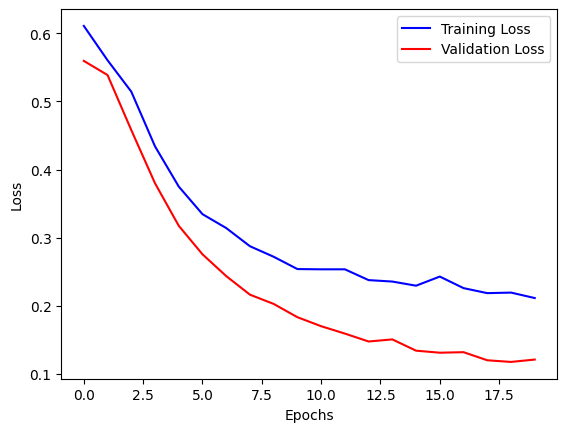

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 41/41 [00:04<00:00, 10.23it/s]
Train performance accuracy: 96.78%
Test performance accuracy:  96.76%
Train performance Precision: 96.11%
Test performance Precision:  97.37%
Train performance Recall: 90.78%
Test performance Recall:  88.90%
Train performance f1 Score: 0.93
Test performance f1 Score:  0.93
time: 373.6692795753479
Avg time per epoch: 18.683463978767396


In [65]:


# Train the first model (Pure Quantum)
print("Training Pure Quantum Model...")
model_quantum, result_quantum, avg_epoch_time_quantum, test_y_quantum, test_prob_quantum = train_graph_classifier(
    model_name="QGCN_Quantum",
    c_hidden=6,
    layer_name="QGCN",
    num_layers=2,
    num_epochs=num_epochs,
    dp_rate_linear=0.5,
    dp_rate=0.0,
    version=0  # Pure Quantum
)

# Display metrics
print(f"Train performance accuracy: {100.0 * result_quantum[0]['train']:4.2f}%")
print(f"Test performance accuracy:  {100.0 * result_quantum[0]['test']:4.2f}%")

print(f"Train performance Precision: {100.0 * result_quantum[2]['train']:4.2f}%")
print(f"Test performance Precision:  {100.0 * result_quantum[2]['test']:4.2f}%")

print(f"Train performance Recall: {100.0 * result_quantum[3]['train']:4.2f}%")
print(f"Test performance Recall:  {100.0 * result_quantum[3]['test']:4.2f}%")

print(f"Train performance f1 Score: {result_quantum[4]['train']:4.2f}")
print(f"Test performance f1 Score:  {result_quantum[4]['test']:4.2f}")

print(f"time: {avg_epoch_time_quantum * num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time_quantum}")

# # Plot confusion matrix for Pure Quantum Model
# cm_quantum = confusion_matrix(test_y_quantum, test_prob_quantum.argmax(axis=1))
# ConfusionMatrixDisplay(cm_quantum).plot()
# plt.title("Confusion Matrix - Pure Quantum")
# plt.show()

# Clear RAM
# del model_quantum, test_y_quantum, test_prob_quantum
# torch.cuda.empty_cache()


Seed set to 42
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                           | Type              | Params | Mode 
------------------------------------------------------------------------------
0  | model                          | GraphGNNModel     | 127    | train
1  | model.embed                    | Linear            | 36     | train
2  | model.dropout_embed            | Dropout           | 0      | train
3  | model.qgnn_layer               | ModuleList        | 84     | train
4  | model.qgnn_layer.0             | GCNConv           | 42     | train
5  | model.qgnn_layer.0.aggr_module | SumAggregation    | 0      | train
6  | model.qgnn_layer.0.lin         | Linear            | 36     | train
7  | model.qgnn_layer.1          


Training Pure Classical Model...
Epoch 0: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 93.52it/s, v_num=6]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 116.77it/s]
Epoch 1: 100%|█| 41/41 [00:00<00:00, 82.60it/s, v_num=6, val_acc=0.750, val_loss=0.529, train_loss=0.600, train_acc=0.6
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 123.56it/s]
Epoch 2: 100%|█| 41/41 [00:00<00:00, 93.03it/s, v_num=6, val_acc=0.787, val_loss=0.351, train_loss=0.459, train_acc=0.7
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Valida

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 41/41 [00:00<00:00, 72.85it/s, v_num=6, val_acc=0.964, val_loss=0.105, train_loss=0.135, train_acc=0.


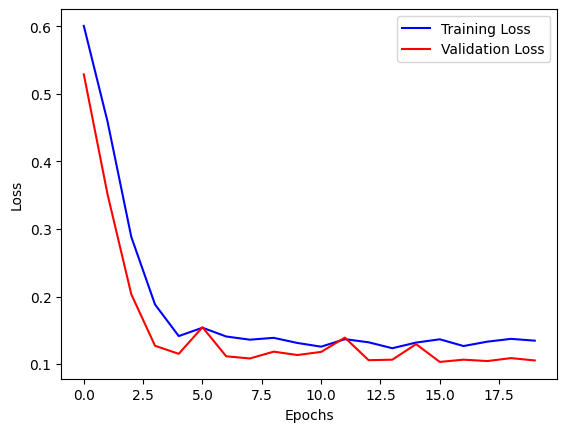

Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 120.36it/s]
Train performance accuracy: 96.53%
Test performance accuracy:  96.43%
Train performance Precision: 94.96%
Test performance Precision:  95.64%
Train performance Recall: 90.33%
Test performance Recall:  91.33%
Train performance f1 Score: 0.92
Test performance f1 Score:  0.93
time: 11.917137145996094
Avg time per epoch: 0.5958568572998046


In [66]:
# Train the second model (Pure Classical)
print("\nTraining Pure Classical Model...")
model_classical, result_classical, avg_epoch_time_classical, test_y_classical, test_prob_classical = train_graph_classifier(
    model_name="QGCN_Classical",
    c_hidden=6,
    layer_name="QGCN",
    num_layers=2,
    num_epochs=num_epochs,
    dp_rate_linear=0.5,
    dp_rate=0.0,
    version=1  # Pure Classical
)

# Display metrics
print(f"Train performance accuracy: {100.0 * result_classical[0]['train']:4.2f}%")
print(f"Test performance accuracy:  {100.0 * result_classical[0]['test']:4.2f}%")

print(f"Train performance Precision: {100.0 * result_classical[2]['train']:4.2f}%")
print(f"Test performance Precision:  {100.0 * result_classical[2]['test']:4.2f}%")

print(f"Train performance Recall: {100.0 * result_classical[3]['train']:4.2f}%")
print(f"Test performance Recall:  {100.0 * result_classical[3]['test']:4.2f}%")

print(f"Train performance f1 Score: {result_classical[4]['train']:4.2f}")
print(f"Test performance f1 Score:  {result_classical[4]['test']:4.2f}")

print(f"time: {avg_epoch_time_classical * num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time_classical}")

# # Plot confusion matrix for Pure Classical Model
# cm_classical = confusion_matrix(test_y_classical, test_prob_classical.argmax(axis=1))
# ConfusionMatrixDisplay(cm_classical).plot()
# plt.title("Confusion Matrix - Pure Classical")
# plt.show()

# Clear RAM
# del model_classical, test_y_classical, test_prob_classical
# torch.cuda.empty_cache()

Seed set to 42
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.



Training Hybrid Model...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                           | Type              | Params | Mode 
------------------------------------------------------------------------------
0  | model                          | GraphGNNModel     | 91     | train
1  | model.embed                    | Linear            | 36     | train
2  | model.dropout_embed            | Dropout           | 0      | train
3  | model.qgnn_layer               | ModuleList        | 48     | train
4  | model.qgnn_layer.0             | QGCNConv          | 24     | train
5  | model.qgnn_layer.0.aggr_module | SumAggregation    | 0      | train
6  | model.qgnn_layer.0.lin         | QuantumNet        | 24     | train
7  | model.qgnn_layer.1             | QGCNConv          | 24     | train
8  | model.qgnn_layer.1.aggr_module | SumAggregation    | 0      | train
9  | model.qgnn_layer.1.lin         | QuantumNet        | 24     | train
10 | m

Epoch 0: 100%|████████████████████████████████████████████████████████████████| 41/41 [02:13<00:00,  0.31it/s, v_num=7]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s]
Epoch 1: 100%|█| 41/41 [00:39<00:00,  1.03it/s, v_num=7, val_acc=0.750, val_loss=0.560, train_loss=0.611, train_acc=0.7
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 60.41it/s]
Epoch 2: 100%|█| 41/41 [00:12<00:00,  3.22it/s, v_num=7, val_acc=0.750, val_loss=0.539, train_loss=0.560, train_acc=0.7
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 41/41 [00:01<00:00, 30.50it/s, v_num=7, val_acc=0.968, val_loss=0.121, train_loss=0.211, train_acc=0.


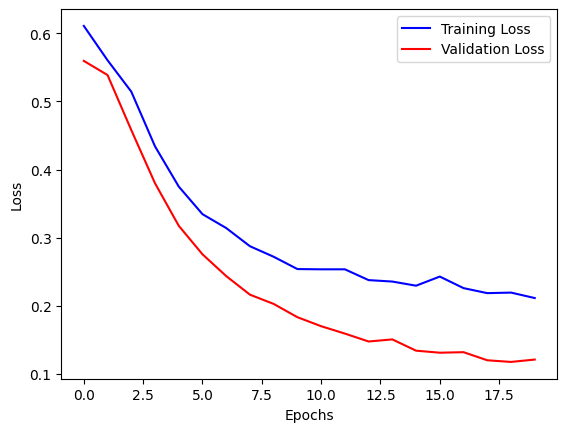

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 10.57it/s]
Train performance accuracy: 96.78%
Test performance accuracy:  96.76%
Train performance Precision: 96.11%
Test performance Precision:  97.37%
Train performance Recall: 90.78%
Test performance Recall:  88.90%
Train performance f1 Score: 0.93
Test performance f1 Score:  0.93
time: 366.4172649383545
Avg time per epoch: 18.320863246917725


AttributeError: 'list' object has no attribute 'argmax'

In [67]:
# Train the third model (Hybrid)
print("\nTraining Hybrid Model...")
model_hybrid, result_hybrid, avg_epoch_time_hybrid, test_y_hybrid, test_prob_hybrid = train_graph_classifier(
    model_name="QGCN_Hybrid",
    c_hidden=6,
    layer_name="QGCN",
    num_layers=2,
    num_epochs=num_epochs,
    dp_rate_linear=0.5,
    dp_rate=0.0,
    version=2  # Hybrid
)

# Display metrics
print(f"Train performance accuracy: {100.0 * result_hybrid[0]['train']:4.2f}%")
print(f"Test performance accuracy:  {100.0 * result_hybrid[0]['test']:4.2f}%")

print(f"Train performance Precision: {100.0 * result_hybrid[2]['train']:4.2f}%")
print(f"Test performance Precision:  {100.0 * result_hybrid[2]['test']:4.2f}%")

print(f"Train performance Recall: {100.0 * result_hybrid[3]['train']:4.2f}%")
print(f"Test performance Recall:  {100.0 * result_hybrid[3]['test']:4.2f}%")

print(f"Train performance f1 Score: {result_hybrid[4]['train']:4.2f}")
print(f"Test performance f1 Score:  {result_hybrid[4]['test']:4.2f}")

print(f"time: {avg_epoch_time_hybrid * num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time_hybrid}")

# Plot confusion matrix for Hybrid Model
cm_hybrid = confusion_matrix(test_y_hybrid, test_prob_hybrid.argmax(axis=1))
ConfusionMatrixDisplay(cm_hybrid).plot()
plt.title("Confusion Matrix - Hybrid")
plt.show()

# Clear RAM
# del model_hybrid, test_y_hybrid, test_prob_hybrid
# torch.cuda.empty_cache()